# Automated Generation of Trendlines & Channels

This notebook will provide a codebase for you to experiment with generating Trendlines and Channels - typical Technical Analysis tools in a programmatic fashion using our Refinitiv Data Libraries, some linear algebra and Python. Our intention is to provide a functioning codebase which you can then take on and experiment with. 

Principally we will be generating some novel features which many participants in markets believe to be helpful in:

* establishing prevailing direction, trend and strengths of prices

    
* providing potential support and resistance points in the future

    
* guaging the potential relevance of trendlines

      
    * Number of touches, bounces, breaks 
    
       
    * Can form the basis of enhanced alerts capability
    
       
    * Of course, people most interested in generating high probability trade signals

#### Learn more

To learn more about the Data Library for Python please join the LSEG Developer Community. By [registering](https://developers.lseg.com/iam/register) and [logging](https://developers.lseg.com/content/devportal/en_us/initCookie.html) into the LSEG Developer Community portal you will have free access to a number of learning materials like 
 [Quick Start guides](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start), 
 [Tutorials](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/tutorials), 
 [Documentation](https://developers.lseg.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/documentation)
 and much more.

#### Getting Help and Support

If you have any questions regarding using the API, please post them on 
this [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/index.html). 
The LSEG Developer Community will be happy to help. 

## Import libraries

In [1]:
import math
import sys
import refinitiv.data as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from datetime import timedelta

rd.open_session()

<refinitiv.data.session.Definition object at 0x31c24cf10 {name='workspace'}>

## Functions

> ### find_next_flat_local_extreme - returns a dictionary of global extrema prices with dates

In [2]:
def find_next_flat_local_extreme(data, points, extreme_type='min'):
    trendline_vals = {}
    if points is not None and len(points) > 0:
        if extreme_type == 'min':
            global_extreme_index = data[points].idxmin() #Global Minima
        else:
            global_extreme_index = data[points].idxmax() #Global Maxima
        
        global_extreme_value = data[global_extreme_index]
        trendline_vals[f'global_{extreme_type}'] = {global_extreme_index: global_extreme_value}

        local_extremes_after = [point for point in points if point > global_extreme_index] #main condition to generate following extrema
        flattest_slope = None
        local_extreme_after_index = None

        for extreme_index in local_extremes_after:
            time_diff = (pd.to_datetime(extreme_index) - pd.to_datetime(global_extreme_index)).days #units of time
            slope = (data[extreme_index] - global_extreme_value) / time_diff  # slope
            
            if flattest_slope is None or abs(slope) < abs(flattest_slope):
                flattest_slope = slope
                local_extreme_after_index = extreme_index

        if local_extreme_after_index is not None:
            trendline_vals[f'local_{extreme_type}_after'] = {local_extreme_after_index: data[local_extreme_after_index]}

    return trendline_vals

> ### get_extreme_points - returns an list of index values for extreme points

In [13]:
def get_extreme_points(data, extreme_type= 'min'):
 
    data = data.dropna()
    if extreme_type == 'min':
        extreme_points, _ = find_peaks(-data, width=5)
    elif extreme_type == 'max':
        extreme_points, _ = find_peaks(data, width=5)
    else:
        print('Please provide valid extreme type')
        sys.exit()
 
    points_index = data[extreme_points].index
 
    if extreme_type == 'min':
        if data[-1] < np.median(data[extreme_points]):
            points_index = pd.DatetimeIndex(list(points_index) + [data.index[-1]])
        elif data[0] < np.median(data[extreme_points]):
            points_index = pd.DatetimeIndex([data.index[0]] + list(points_index))
    else:
        if data[-1] > np.median(data[extreme_points]):
            points_index =  pd.DatetimeIndex(list(points_index) + [data.index[-1]])
        elif data[0] > np.median(data[extreme_points]):
            points_index = pd.DatetimeIndex([data.index[0]] + list(points_index))
 
    return points_index

> ### extrapolate_y_value - returns an extrapolation of time values

In [14]:
def extrapolate_y_value(date1, y1, date2, y2, date3):

    delta_days_1_2 = (date2 - date1).days
    delta_days_1_3 = (date3 - date1).days
    change_per_day = (y2 - y1) / delta_days_1_2    
    y3 = y1 + change_per_day * delta_days_1_3
    
    return y3

> ### extrapolate_prices - returns an extrapolation of time and price values

In [15]:
def extrapolate_prices(data, trendline_vals, extrapolate_n, extreme_type = 'min'):
    extrapolated_vals = {}
    global_date = list(trendline_vals[f'global_{extreme_type}'].keys())[0]
    global_price = list(trendline_vals[f'global_{extreme_type}'].values())[0]

    if f'local_{extreme_type}_after' in list(trendline_vals.keys()):
        local_after_date = list(trendline_vals[f'local_{extreme_type}_after'].keys())[0]
        local_after_price = list(trendline_vals[f'local_{extreme_type}_after'].values())[0]
    else:
        print(f'Global {extreme_type} is also the local {extreme_type}, will not be able to provide line for {extreme_type}')
        return []
    date1, y1 = global_date, global_price
    date2, y2 = local_after_date, local_after_price
    for date in data.index:
        extrapolated_vals[date] = extrapolate_y_value(date1, y1, date2, y2, date)
    for _ in range(1, extrapolate_n):
        date += timedelta(days=1)
        extrapolated_vals[date] = extrapolate_y_value(date1, y1, date2, y2, date)


    return pd.Series(extrapolated_vals)


> ### get_offset - calculates the parallel channel offset

In [16]:
def get_offset(data, eligible_locals, extraploated_data_df, extreme_type = 'max'):
    if len(eligible_locals) and len(extraploated_data_df):
        dates, prices = extraploated_data_df.index, extraploated_data_df.values
        for i, local_val in enumerate(eligible_locals.index):
            extrapolated_val = extrapolate_y_value(dates[0], prices[0], dates[1], prices[1], local_val)
            offset_val = abs(extrapolated_val - data[local_val])
            extraploated_data_df_offset = extraploated_data_df - offset_val if extreme_type == 'max' else extraploated_data_df + offset_val
            for j, next_local_val in enumerate(eligible_locals.index[i+1:]):
                extrapolated_val_next = extrapolate_y_value(dates[0], prices[0], dates[1], prices[1], next_local_val)
                if (extreme_type == 'min' and extrapolated_val_next + 
                    offset_val < eligible_locals[next_local_val]) or \
                (extreme_type == 'max' and extrapolated_val_next - offset_val > eligible_locals[next_local_val]):
                    break
                elif j == len(eligible_locals.index[i+1:]) - 1:
                    return extraploated_data_df_offset
                else:
                    continue
        return extraploated_data_df_offset
    else:
        print("There are no eligible locals")

> ### build_feature_df - builds main dataframe containing all features to be used in plotting

In [17]:
def build_feature_df(prices_df, sector_df):
    all_stock_df = {}
    keys = []
    for stock in sector_df['Instrument']:
        prices_df_stock = prices_df[stock]
        prices = prices_df_stock['TRDPRC_1']
        if not math.isnan(prices[0]):
            peaks_index_stock, lows_index_stock = get_extreme_points(prices, 'max'), get_extreme_points(prices)
            trendline_vals_min_stock = find_next_flat_local_extreme(prices, lows_index_stock)
            trendline_vals_max_stock = find_next_flat_local_extreme(prices, peaks_index_stock, 'max')
            if len(trendline_vals_min_stock) ==  len(trendline_vals_max_stock) == 2:
                extraploated_data_df_min_stock = extrapolate_prices(prices, trendline_vals_min_stock, 100, 'min')
                extraploated_data_df_max_stock = extrapolate_prices(prices, trendline_vals_max_stock, 100, 'max')
                eligible_local_min_stock = prices[lows_index_stock][prices[lows_index_stock].index > list(trendline_vals_max_stock['global_max'].keys())[0]]
                eligible_local_max_stock = prices[peaks_index_stock][prices[peaks_index_stock].index > list(trendline_vals_min_stock['global_min'].keys())[0]]  
                if len(eligible_local_min_stock) > 0 and  len(eligible_local_max_stock) > 0:
                    extraploated_data_df_max_offset_stock = get_offset(prices, eligible_local_min_stock, extraploated_data_df_max_stock, extreme_type = 'max')
                    extraploated_data_df_min_offset_stock = get_offset(prices, eligible_local_max_stock, extraploated_data_df_min_stock, extreme_type = 'min')
                    mid_max_stock  = (extraploated_data_df_max_stock + extraploated_data_df_max_offset_stock)/2
                    mid_min_stock = (extraploated_data_df_min_stock + extraploated_data_df_min_offset_stock)/2
                    
                    new_df = pd.concat([prices_df_stock, extraploated_data_df_max_stock, mid_max_stock, extraploated_data_df_max_offset_stock, extraploated_data_df_min_stock, mid_min_stock, extraploated_data_df_min_offset_stock],axis = 1)
                    new_df.columns = ['open', 'high', 'low', 'close', 'volume', 'down_trend_res','down_trend_mid', 'down_trend_sup',  'up_trend_res',  'up_trend_mid', 'up_trend_sup']
                    new_df['Sector'] = sector_df[sector_df['Instrument'] == stock]['TRBC Industry Group Name'].values[0]
                    for col in new_df[['down_trend_res','down_trend_mid', 'down_trend_sup',  'up_trend_res',  'up_trend_mid', 'up_trend_sup']]:
                        new_df[f'distance_to_close_{col}'] = abs(new_df['close'] - new_df[col])
                    keys.append(stock)
                    all_stock_df[stock] = new_df
                else:
                    print('Missing Eligable local extrema to build offset lines', stock)
            else:
                print('Missing extrema to build offset lines', stock)
        else:
            print("Prices not found", stock)

    all_stock_df = pd.concat(all_stock_df.values(), axis=1, keys=all_stock_df.keys())
    return all_stock_df


> ### plot_trendlines - main plotting routine for prices, extrema, tendlines and alerts

In [23]:
def plot_trendlines(all_stock_df, stock):
    stock_df = all_stock_df[stock]
    
    peaks_index_stock, lows_index_stock = get_extreme_points(stock_df['close'], 'max'), get_extreme_points(stock_df['close'])
    trendline_vals_min_stock = find_next_flat_local_extreme(stock_df['close'], lows_index_stock)
    trendline_vals_max_stock = find_next_flat_local_extreme(stock_df['close'], peaks_index_stock, 'max')

    global_high_date, global_low_date = list(trendline_vals_max_stock['global_max'].keys())[0], list(trendline_vals_min_stock['global_min'].keys())[0]
    figure, axis = plt.subplots(2, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
    axis[0].plot(list(stock_df.index), stock_df['close'])
    axis[0].plot(stock_df['close'][peaks_index_stock],"x")
    axis[0].plot(stock_df['close'][lows_index_stock],"x")
    axis[0].plot(stock_df['down_trend_res'][global_high_date:])
    axis[0].plot(stock_df['down_trend_sup'][global_high_date:])
    axis[0].plot(stock_df['up_trend_res'][global_low_date:])
    axis[0].plot(stock_df['up_trend_sup'][global_low_date:])
    axis[0].plot(stock_df['down_trend_mid'][global_high_date:],linestyle='dashed')
    axis[0].plot(stock_df['up_trend_mid'][global_low_date:],linestyle='dashed')
    axis[0].plot(stock_df[stock_df['distance_to_close_down_trend_mid'] < stock_df['close']/100]['close'][global_high_date:], marker='o', linestyle='none')
    axis[0].plot(stock_df[stock_df['distance_to_close_down_trend_res'] < stock_df['close']/100]['close'][global_high_date:], marker='o', linestyle='none')
    axis[0].plot(stock_df[stock_df['distance_to_close_down_trend_sup'] < stock_df['close']/100]['close'][global_high_date:], marker='o', linestyle='none')
    axis[0].plot(stock_df[stock_df['distance_to_close_up_trend_mid'] < stock_df['close']/100]['close'][global_low_date:], marker='o', linestyle='none')
    axis[0].plot(stock_df[stock_df['distance_to_close_up_trend_res'] < stock_df['close']/100]['close'][global_low_date:], marker='o', linestyle='none')
    axis[0].plot(stock_df[stock_df['distance_to_close_up_trend_sup'] < stock_df['close']/100]['close'][global_low_date:], marker='o', linestyle='none')
    axis[1].bar(list(stock_df.index), stock_df['volume'])
    axis[1].plot(stock_df['down_trend_sup'][global_high_date:], color='w')
    figure.suptitle(f'Generated trendlines for {stock}', fontsize=12)
    plt.show()

## RD Lib API call to get list of FTSE components

> #### can also be a list of your own universe=["PORTFOLIO(your_portfolio)"]

In [9]:
sector_df = rd.get_data(universe=["0#.FTSE"], fields="TR.TRBCIndustryGroup")
sector_df

,Instrument,TRBC Industry Group Name
0,STAN.L,Banking Services
1,CRDA.L,Chemicals
2,ANTO.L,Metals & Mining
3,EZJ.L,Passenger Transportation Services
4,BNZL.L,Diversified Industrial Goods Wholesale
...,...,...
95,ULVR.L,Personal & Household Products & Services
96,OCDO.L,Diversified Retail
97,LSEG.L,Investment Banking & Investment Services
98,TSCO.L,Food & Drug Retailing


## RD Lib API call to get OHLCV prices for all index components

In [10]:
prices_df = rd.get_history(universe=sector_df['Instrument'].to_list(), fields=["OPEN_PRC", "HIGH_1", "LOW_1","TRDPRC_1","ACVOL_UNS"], interval="1D",
               start = '2020-01-01', end = '2023-02-28'
               ).astype(float)
prices_df

STAN.L                                        CRDA.L          \
           OPEN_PRC HIGH_1  LOW_1   TRDPRC_1   ACVOL_UNS OPEN_PRC  HIGH_1   
Date                                                                        
2020-01-02    712.4  724.0  711.0  720.00000   2575708.0   5140.0  5155.0   
2020-01-03    713.2  720.8  709.6  712.40000   3080904.0   5065.0  5095.0   
2020-01-06    712.0  712.4  698.4  707.00000   4476137.0   5040.0  5120.0   
2020-01-07    707.6  709.4  698.6  701.60000   4105906.0   5095.0  5130.0   
2020-01-08    695.2  700.8  687.0  698.80000   3839053.0   5065.0  5130.0   
...             ...    ...    ...        ...         ...      ...     ...   
2023-02-22    762.6  768.0  754.2  761.59805   4614157.0   6956.0  7018.0   
2023-02-23    754.6  764.8  740.2  746.19640   6940982.0   7006.0  7040.0   
2023-02-24    760.4  779.0  760.4  770.92722   9527808.0   6962.0  6992.0   
2023-02-27    775.0  795.6  769.8  785.76366   4304753.0   6944.0  6986.0   
2023-02-28    783.2  799.4  777.0  790.70229  14059495.0   6710.0  6766.0   

                                          ...      TSCO.L              \
             LOW_1    TRDPRC_1 ACVOL_UNS  ...    OPEN_PRC      HIGH_1   
Date                                      ...                           
2020-01-02  5100.0  5100.00000  242938.0  ...  255.825998  257.523517   
2020-01-03  5060.0  5080.00000  170932.0  ...  252.530816  255.825998   
2020-01-06  5025.0  5095.00000  310614.0  ...  252.730524  254.827458   
2020-01-07  5080.0  5090.00000  250812.0  ...  253.729064  257.423663   
2020-01-08  5060.0  5070.00000  294682.0  ...  251.532275  253.129940   
...            ...         ...       ...  ...         ...         ...   
2023-02-22  6856.0  6909.42857  208899.0  ...  250.000000  250.400000   
2023-02-23  6922.0  6967.57143  213505.0  ...  248.600000  250.500000   
2023-02-24  6840.0  6864.00000  230646.0  ...  249.600000  249.700000   
2023-02-27  6852.0  6906.00000  417303.0  ...  247.100000  255.700000   
2023-02-28  6490.0  6641.18423  726460.0  ...  254.900000  257.000000   

                                                   LGEN.L                \
                 LOW_1    TRDPRC_1     ACVOL_UNS OPEN_PRC HIGH_1  LOW_1   
Date                                                                      
2020-01-02  254.827458  255.426582  1.027754e+07    306.2  312.4  305.3   
2020-01-03  251.532275  254.727604  1.010448e+07    311.7  311.7  304.8   
2020-01-06  251.432421  253.629210  1.352464e+07    303.1  305.0  300.0   
2020-01-07  253.229794  254.128480  1.333619e+07    305.7  310.0  304.3   
2020-01-08  248.836217  251.831837  1.634691e+07    305.5  308.8  303.1   
...                ...         ...           ...      ...    ...    ...   
2023-02-22  247.000000  248.875670  9.772313e+06    252.7  254.6  250.3   
2023-02-23  248.600000  248.600000  5.971795e+07    251.8  255.4  251.8   
2023-02-24  246.500000  247.526610  1.184028e+07    254.1  256.3  252.6   
2023-02-27  245.900000  252.246020  2.905654e+07    255.9  258.1  255.4   
2023-02-28  252.300000  253.899100  2.364098e+07    255.9  260.2  254.2   

                                   
             TRDPRC_1   ACVOL_UNS  
Date                               
2020-01-02  311.00000   7050074.0  
2020-01-03  306.00000   6748738.0  
2020-01-06  305.00000   8927857.0  
2020-01-07  307.20000  10273506.0  
2020-01-08  308.10000   9797101.0  
...               ...         ...  
2023-02-22  251.42742  11341810.0  
2023-02-23  253.70000  15770130.0  
2023-02-24  253.59527   7764974.0  
2023-02-27  256.60000  11861717.0  
2023-02-28  255.79566  16909936.0  

[799 rows x 500 columns]

## Execute generation of main feature dataframe given our OHLC data and Instrument list

In [19]:
all_stock_df = build_feature_df(prices_df, sector_df)
all_stock_df

Missing extrema to build offset lines STAN.L
Missing extrema to build offset lines REL.L
Missing Eligable local extrema to build offset lines SMIN.L
Missing extrema to build offset lines HSBA.L
Missing Eligable local extrema to build offset lines TW.L
Missing extrema to build offset lines III.L
Missing extrema to build offset lines CNA.L
Prices not found HLN.L
Missing Eligable local extrema to build offset lines IMB.L
Missing Eligable local extrema to build offset lines BRBY.L
Missing Eligable local extrema to build offset lines BP.L
Prices not found ADML.L
Prices not found RTO.L
Missing Eligable local extrema to build offset lines IHG.L
Prices not found FRAS.L
Missing Eligable local extrema to build offset lines SHEL.L
Missing Eligable local extrema to build offset lines VOD.L
Missing Eligable local extrema to build offset lines FCIT.L
Missing extrema to build offset lines BAES.L


CRDA.L                                                   \
              open    high     low   close    volume down_trend_res   
2020-01-02  5140.0  5155.0  5100.0  5100.0  242938.0   15871.300716   
2020-01-03  5065.0  5095.0  5060.0  5080.0  170932.0   15863.579952   
2020-01-06  5040.0  5120.0  5025.0  5095.0  310614.0   15840.417661   
2020-01-07  5095.0  5130.0  5080.0  5090.0  250812.0   15832.696897   
2020-01-08  5065.0  5130.0  5060.0  5070.0  294682.0   15824.976134   
...            ...     ...     ...     ...       ...            ...   
2023-06-03     NaN     NaN     NaN     NaN       NaN    6235.787589   
2023-06-04     NaN     NaN     NaN     NaN       NaN    6228.066826   
2023-06-05     NaN     NaN     NaN     NaN       NaN    6220.346062   
2023-06-06     NaN     NaN     NaN     NaN       NaN    6212.625298   
2023-06-07     NaN     NaN     NaN     NaN       NaN    6204.904535   

                                                                    ...  \
           down_trend_mid down_trend_sup up_trend_res up_trend_mid  ...   
2020-01-02   14362.552506   12853.804296  3873.243325  6324.148601  ...   
2020-01-03   14354.831742   12846.083532  3875.545509  6326.450785  ...   
2020-01-06   14331.669451   12822.921241  3882.452060  6333.357336  ...   
2020-01-07   14323.948687   12815.200477  3884.754244  6335.659520  ...   
2020-01-08   14316.227924   12807.479714  3887.056427  6337.961704  ...   
...                   ...            ...          ...          ...  ...   
2023-06-03    4727.039379    3218.291169  6746.368694  9197.273970  ...   
2023-06-04    4719.318616    3210.570406  6748.670878  9199.576154  ...   
2023-06-05    4711.597852    3202.849642  6750.973061  9201.878338  ...   
2023-06-06    4703.877088    3195.128878  6753.275245  9204.180521  ...   
2023-06-07    4696.156325    3187.408115  6755.577429  9206.482705  ...   

                 LGEN.L                            \
           up_trend_res up_trend_mid up_trend_sup   
2020-01-02   132.482394   197.094692   261.706990   
2020-01-03   132.557920   197.170218   261.782516   
2020-01-06   132.784498   197.396796   262.009094   
2020-01-07   132.860024   197.472322   262.084620   
2020-01-08   132.935550   197.547848   262.160146   
...                 ...          ...          ...   
2023-06-03   226.738837   291.351135   355.963433   
2023-06-04   226.814363   291.426661   356.038959   
2023-06-05   226.889889   291.502187   356.114485   
2023-06-06   226.965415   291.577713   356.190011   
2023-06-07   227.040941   291.653239   356.265537   

                                                      \
                                              Sector   
2020-01-02  Investment Banking & Investment Services   
2020-01-03  Investment Banking & Investment Services   
2020-01-06  Investment Banking & Investment Services   
2020-01-07  Investment Banking & Investment Services   
2020-01-08  Investment Banking & Investment Services   
...                                              ...   
2023-06-03  Investment Banking & Investment Services   
2023-06-04  Investment Banking & Investment Services   
2023-06-05  Investment Banking & Investment Services   
2023-06-06  Investment Banking & Investment Services   
2023-06-07  Investment Banking & Investment Services   

                                                                              \
           distance_to_close_down_trend_res distance_to_close_down_trend_mid   
2020-01-02                         8.136679                        81.507835   
2020-01-03                        13.121276                        76.523238   
2020-01-06                        14.075066                        75.569448   
2020-01-07                        11.859663                        77.784851   
2020-01-08                        10.944260                        78.700254   
...                                     ...                              ...   
2023-06-03                              NaN          

Count number of valid stocks

In [20]:
print(len(all_stock_df.columns.get_level_values(0).unique()))

81


## Plot charts for all valid stocks

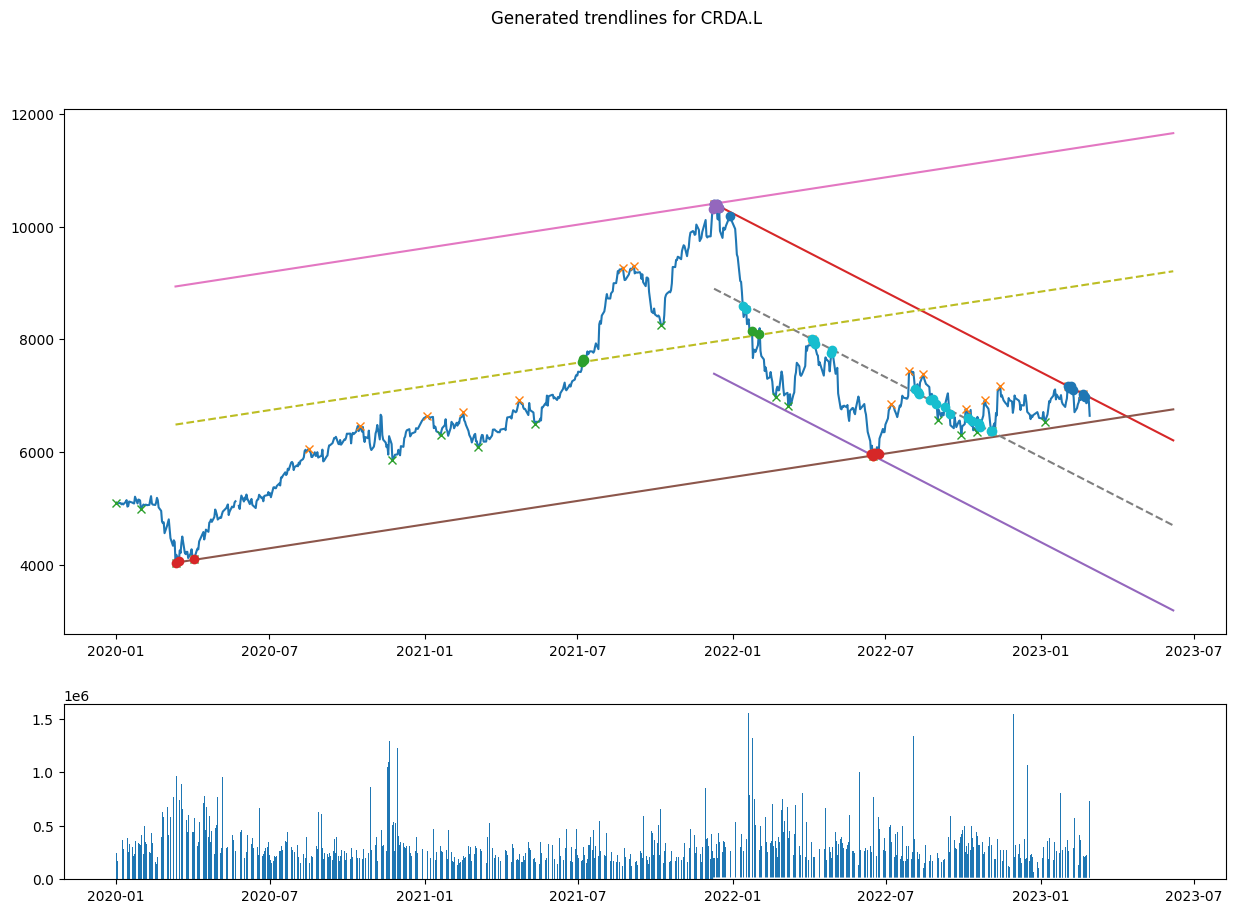

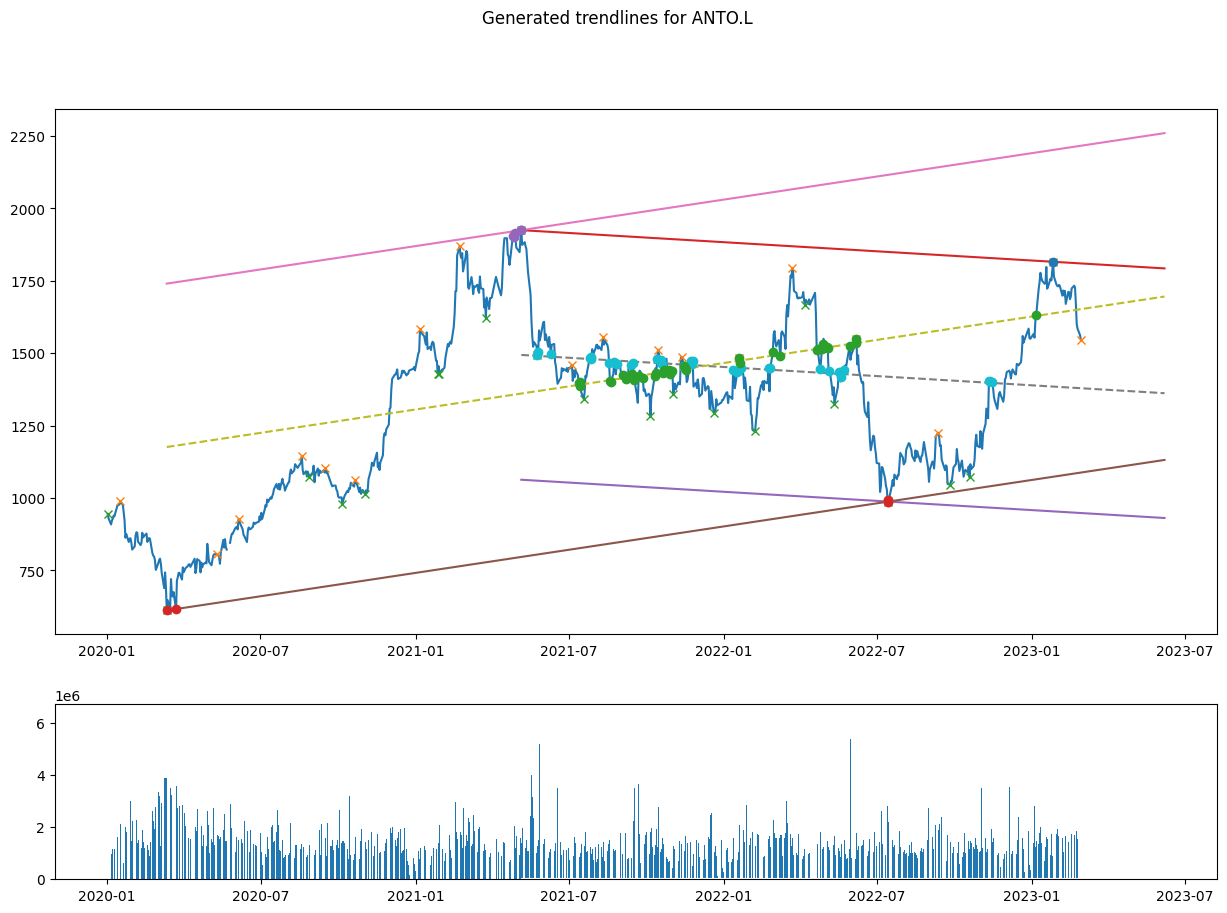

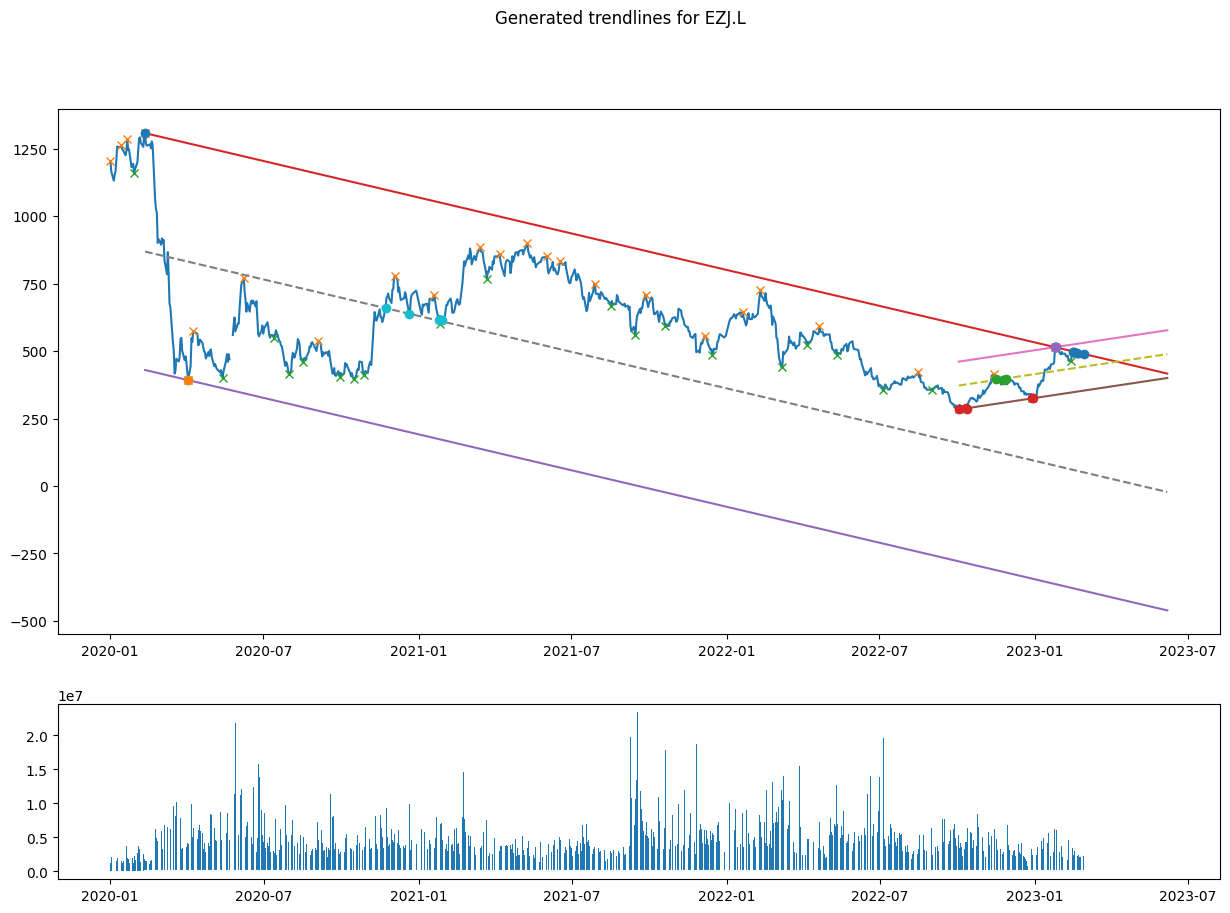

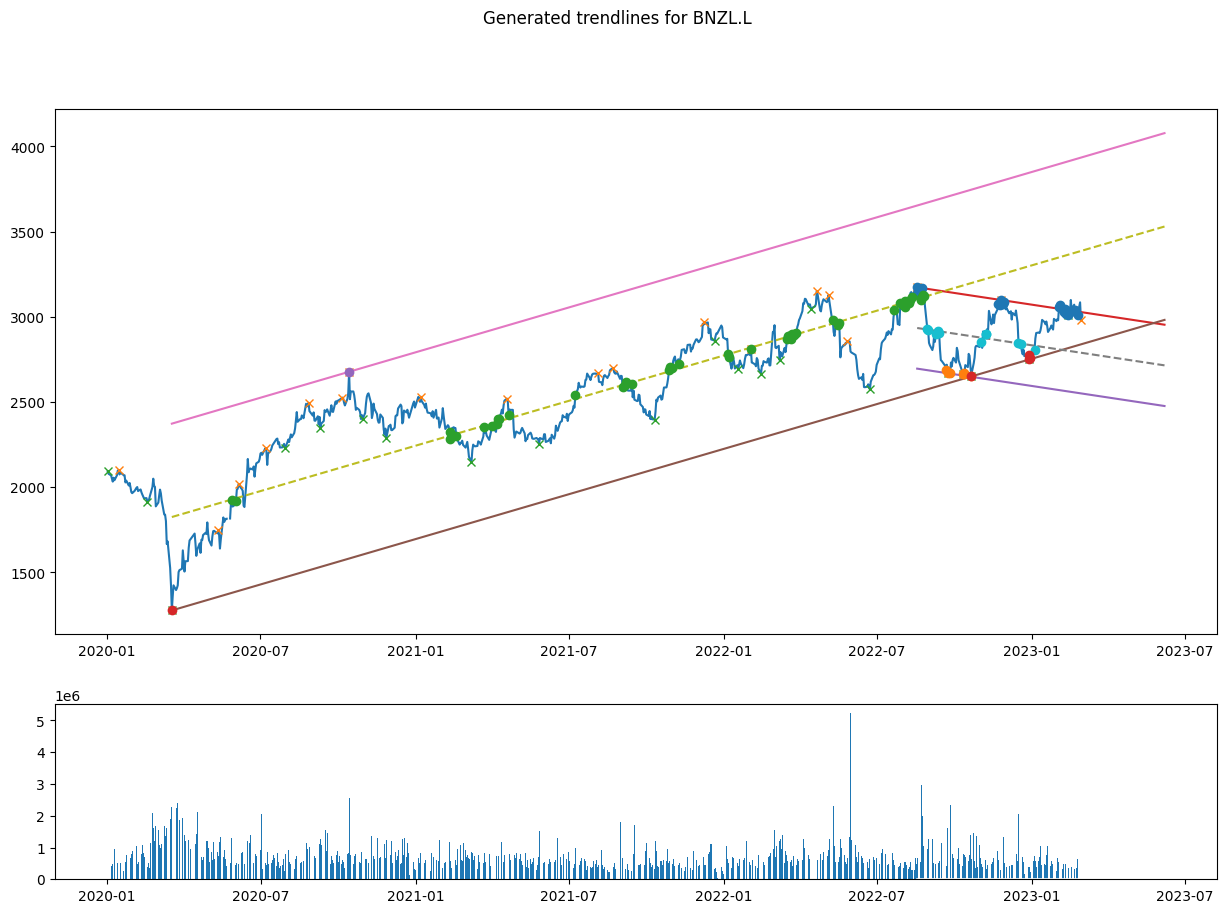

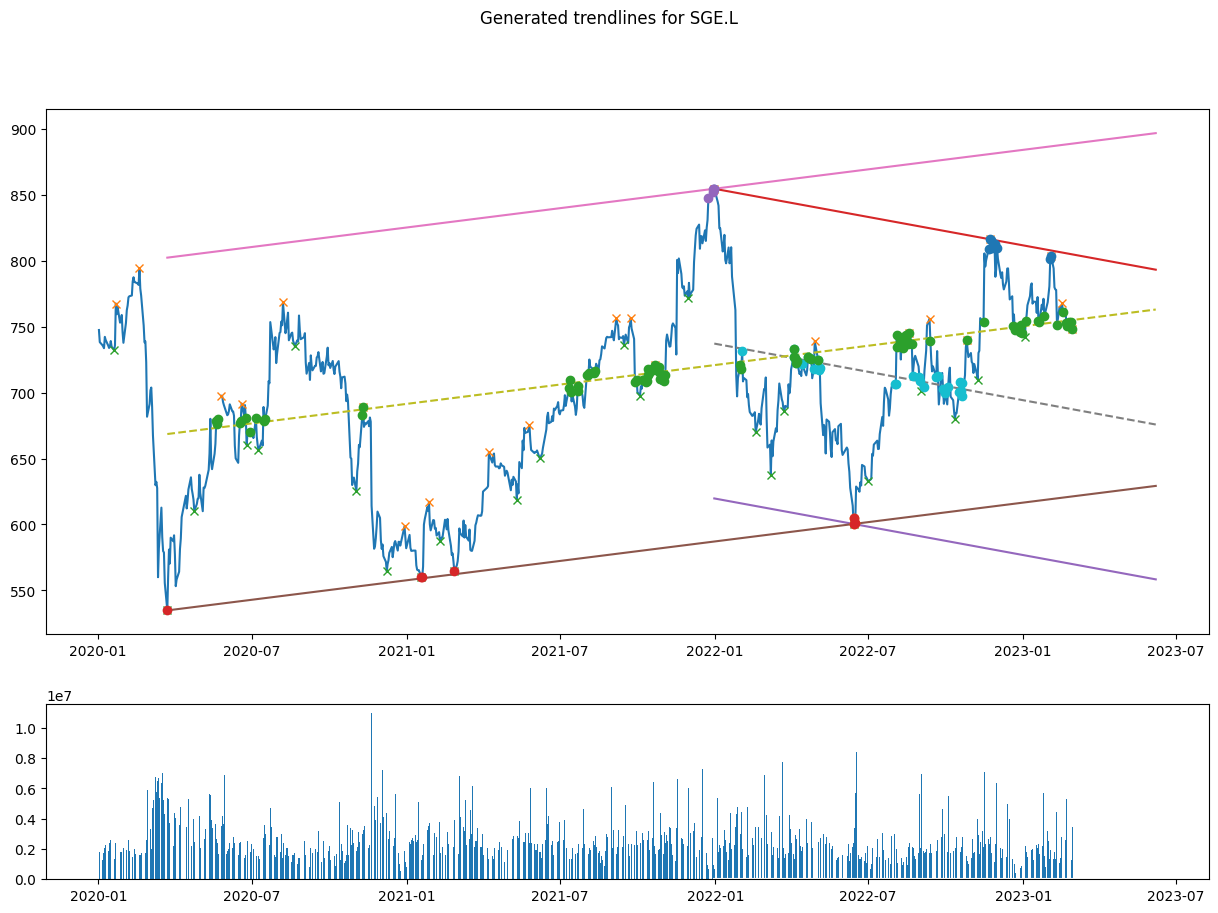

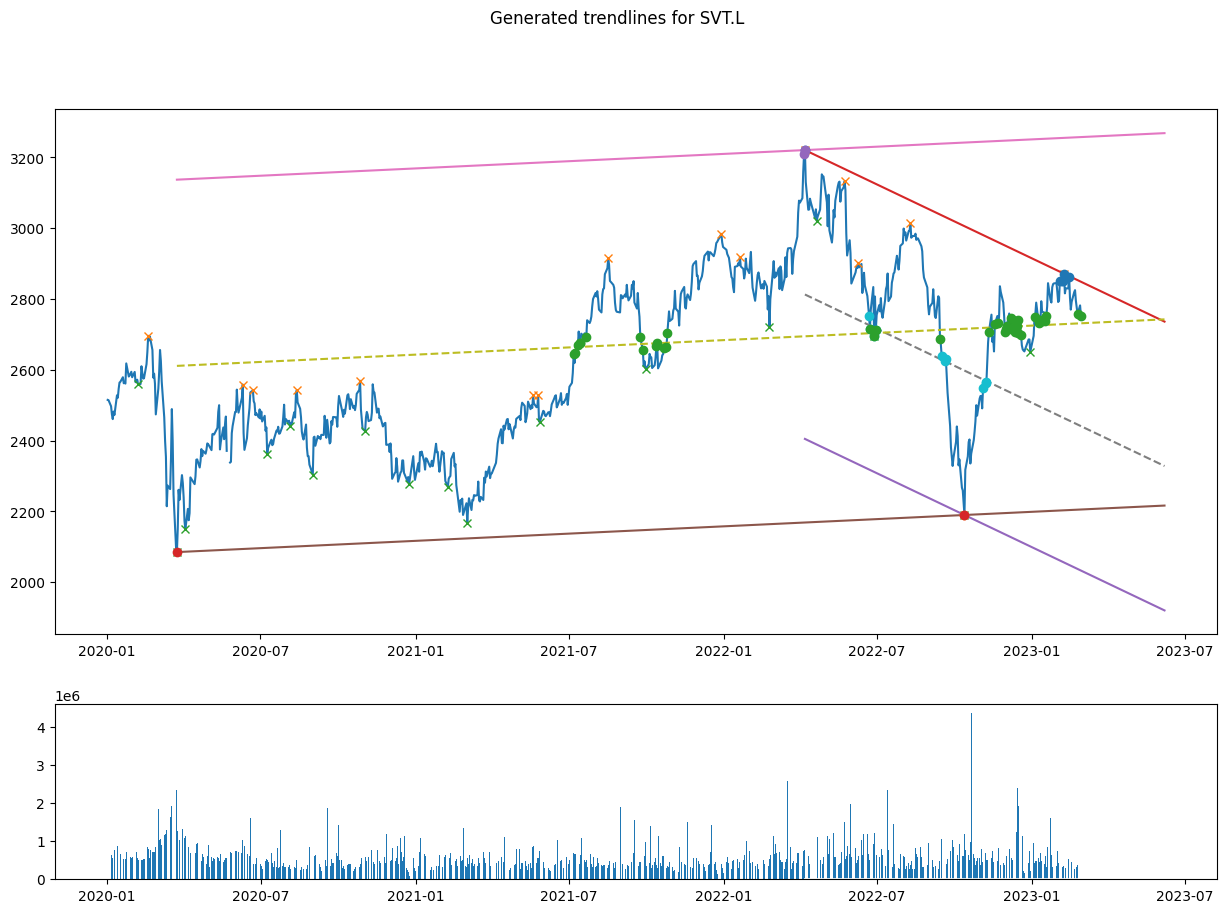

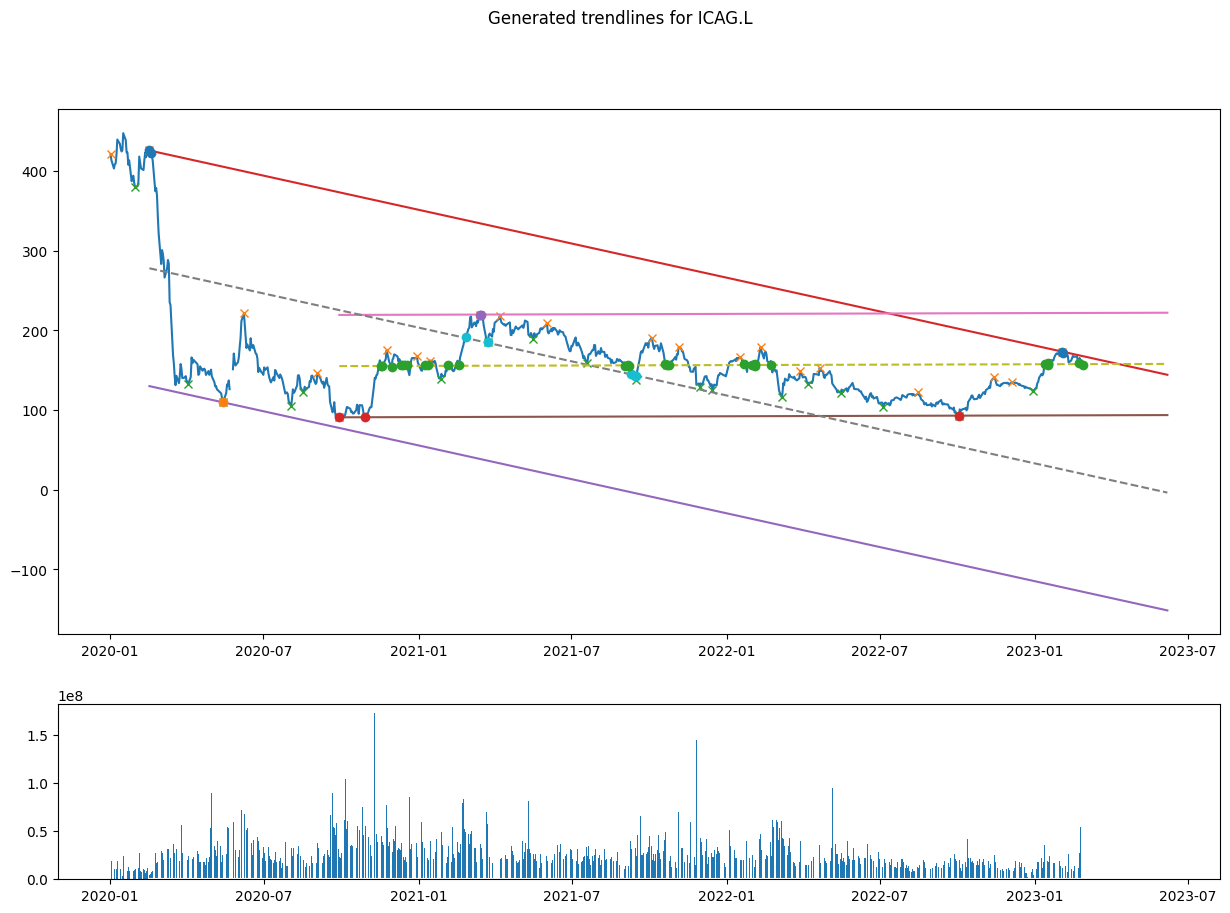

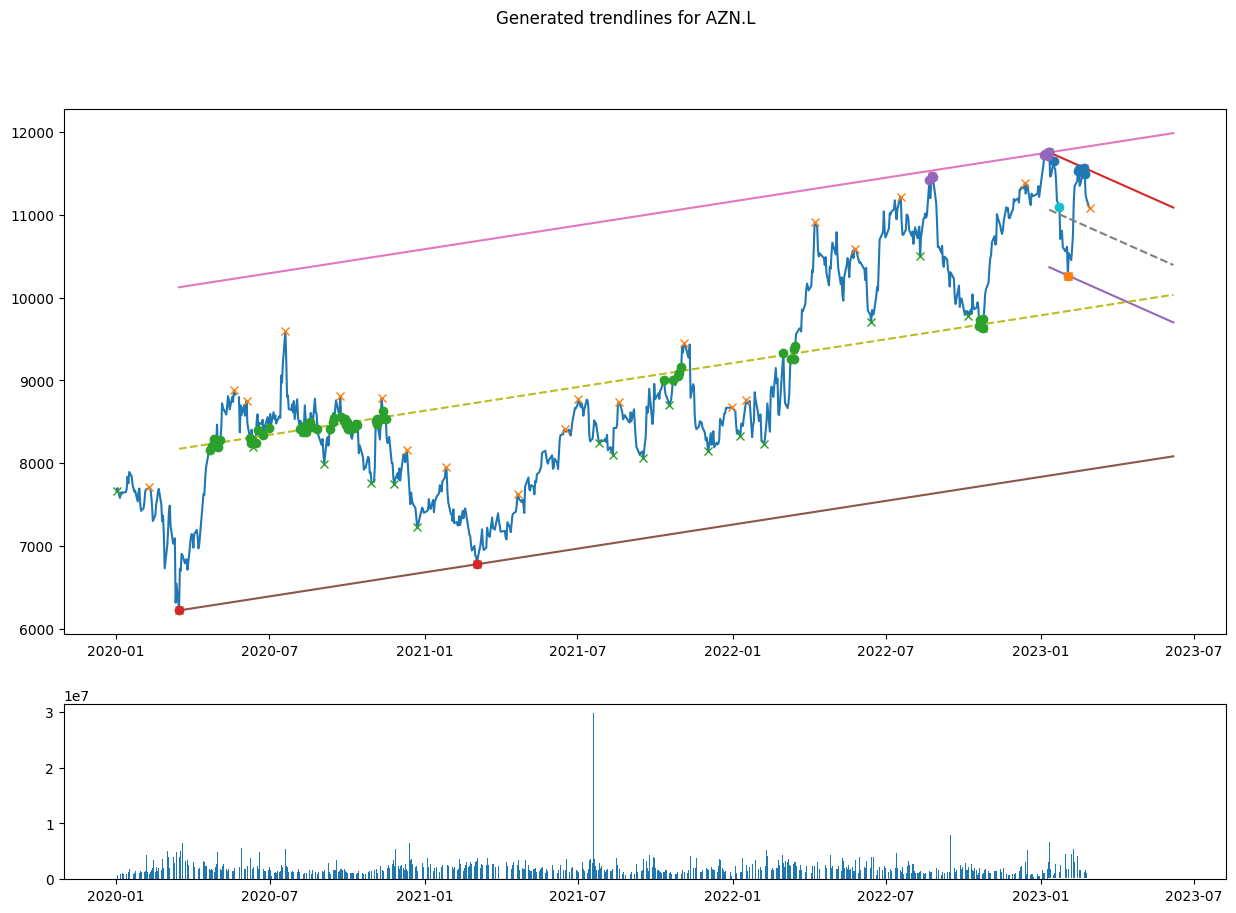

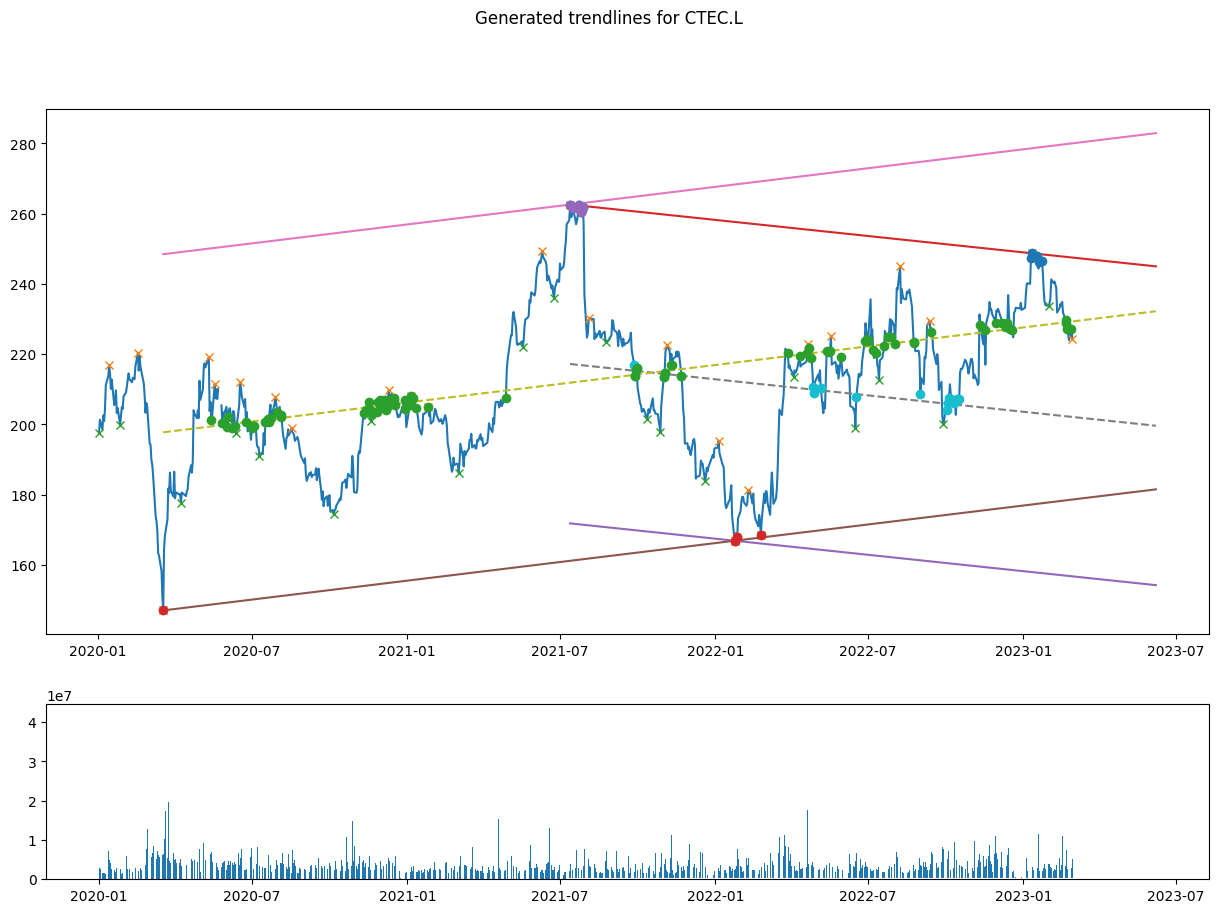

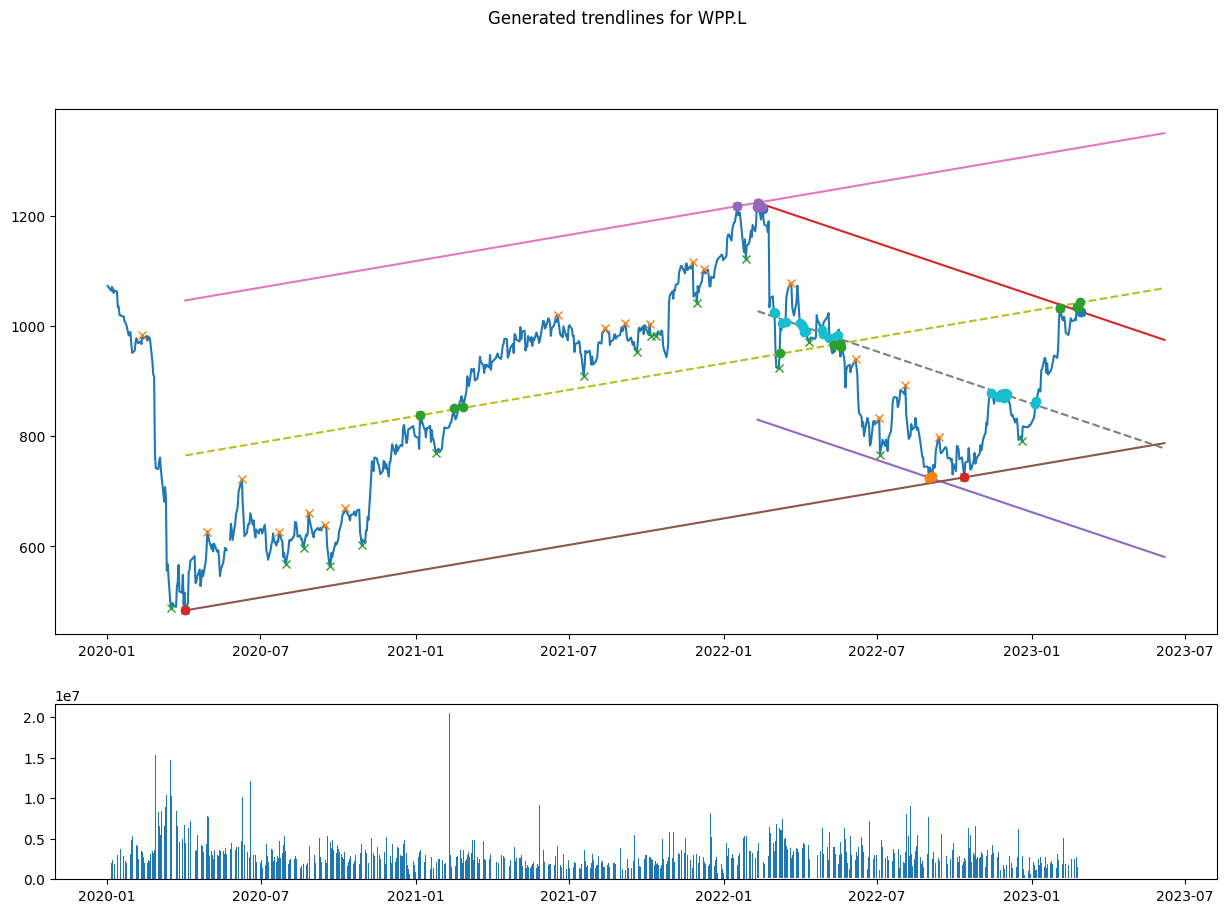

In [24]:
n_stock_to_plot = 10
for stock in all_stock_df.columns.get_level_values(0).unique()[:n_stock_to_plot]:
    try:
        plot_trendlines(all_stock_df, stock)
    except Exception as e:
        print(stock,e)

* ### Conclusion

  * #### Possible to automate trendline and channel generation using simple linear geometry and python
  * #### Possible to calculate potential relevance of lines using novel features
  * #### Possible to provide forward looking timeframes of intersection
  * #### Possible to provide forward looking extrapolations of support and/or resistance
  * #### Compressions might be the interaction of two channels Sup1 with Res2

* ### Possible Extensions

  * #### Identify ascending, decending, equalateral compressions and other novel features
  * #### Add volume confirmation of extrema
  * #### Generate (market cap adjusted) averages for entire sectors
  * #### +++ anything you can imagine
  

In [ ]:
rd.close_session()